In [1]:
import QCircuit
from QCircuit import * 
import sympy 
import matplotlib.pyplot as plt 
import scipy as sp 

In [2]:
import qutip  

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline 
import numpy as np
import qutip 
from tqdm import tqdm
import seaborn as sns
from matplotlib import colors


In [4]:
%config InlineBackend.figure_format = 'retina'

## Что происходит?
Происходит диагонализация гамильтониана системы из 1 кубита (флаксониума) и резонатора. 
Итоговая цель нотебука -- показать, что в такой системе матричный элемент 

\begin{equation} 
\langle q=0, r=0|U^\dagger Q_q U  |q=0, r=1 \rangle 
\end{equation}

Отличается от матричного элемента: 

\begin{equation} 
\langle q=1, r=0|U^\dagger Q_q U  |q=1, r=1 \rangle
\end{equation}




# Часть 1: диагонализация $H_{sys} = H_Q + H_R + V$

## Моя реализация 

Диагонализация единичного флаксониума

All the psi_n(x) are normalized.


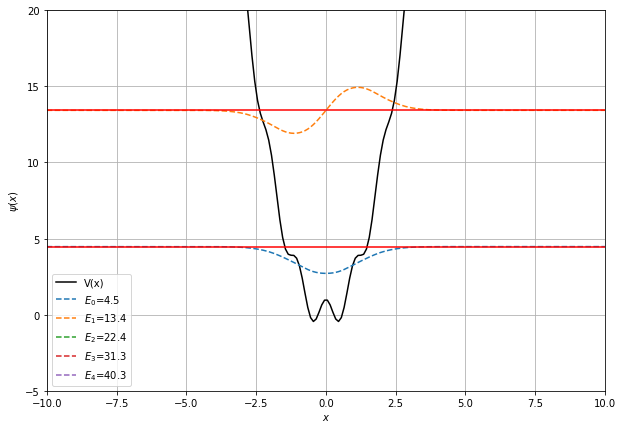

In [2]:



N = 1000
a = 100
x = np.linspace(-a/2.,a/2.,N)
h = x[1] - x[0]

Ec = 1
Ej = 1
El = 5
phi_e = np.pi

V = El / 2 * x*x - Ej*np.cos(2*np.pi*x-phi_e)


Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) - 2*np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))

H = -4*Ec * Mdd + np.diag(V) 

En,psiT = np.linalg.eigh(H) 
En = En / 0.7056583597419407 
psi = np.transpose(psiT) 



notok = False
for n in range(len(psi)):
    # s = np.sum(psi[n]*psi[n])
    s = np.linalg.norm(psi[n])  
    if np.abs(s - 1) > 0.00001: 
        print("Wave function {} is not normalized to 1 but {}".format(n,s))
        notok=True

if not notok:
    print("All the psi_n(x) are normalized.")

fig2 = plt.figure(figsize=[10,7])

plt.ylabel('$\psi(x)$')
plt.xlabel('$x$')
# plt.plot([0,0],[-6,V[0]],color="blue")
# plt.plot([-a/2.,a/2.],[0,0],color="blue")
plt.grid() 

plt.plot(x, V,color="black",label="V(x)")

lim = 20


plt.ylim((-5, lim)) 
plt.xlim((-10., 10.))


M = 10 
for i in range(0,5):
    if psi[i][N//8] < 0:
        plt.plot(x, En[i] - 0.25 * M * psi[i]/np.sqrt(h),label="$E_{}$={}".format(i,En[i]), linestyle='--')
    else:
        plt.plot(x, En[i] + 0.25 * M * psi[i]/np.sqrt(h),label="$E_{}$={:3.1f}".format(i,En[i]), linestyle='--')


plt.legend()

for each in En:
    plt.axhline(y=each, color='r', linestyle='-')

plt.show() 


## На основе готового нотебука 

In [6]:
C_q, C_g, C_r = sympy.symbols('C_q, C_g, C_r', positive=True, real=True)

C = sympy.Matrix([[C_q + C_g, -C_g],
                  [-C_g, C_r + C_g]])

C_inv = sympy.simplify(C.inv())
C_inv 

Matrix([
[(C_g + C_r)/(C_g*C_q + C_g*C_r + C_q*C_r),         C_g/(C_g*C_q + C_g*C_r + C_q*C_r)],
[        C_g/(C_g*C_q + C_g*C_r + C_q*C_r), (C_g + C_q)/(C_g*C_q + C_g*C_r + C_q*C_r)]])

In [7]:
def calculate_fluxonium(EJ, EC, EL, φx_value, num_points=128, periods=4, num_states=8, seed=None):
    fluxonium = QCircuit()
    fluxonium.add_element(QCapacitance('C'), ['GND', '1'])
    fluxonium.add_element(QJosephsonJunction('JJ'), ['GND', '1'])
    fluxonium.add_element(QInductance('L'), ['1', '2'])

    φ = QVariable('φ')
    φx = QVariable('φx')
    fluxonium.add_variable(φ)
    fluxonium.add_variable(φx)

    fluxonium.map_nodes_linear(node_names = ['GND', '1', '2'], 
                               variable_names = ['φ', 'φx'],
                               coefficients = np.asarray([[ 0, 0 ],
                                                          [ 1, 0 ],
                                                          [ 0, 1 ]]))
    
    φ.create_grid(num_points, periods)
    φx.set_parameter(phase_value=φx_value, voltage_value=0)
    
    fluxonium.find_element('L').set_inductance(1/(2*EL))
    fluxonium.find_element('JJ').set_critical_current(EJ)
    fluxonium.find_element('C').set_capacitance(1/(8*EC))
    
    fluxonium.calculate_potentials()
    energies, wavefunctions = fluxonium.diagonalize_phase(num_states=num_states)
    if seed is not None:
        wavefunctions *= np.exp(1j*np.angle(np.sum(np.conj(wavefunctions)*seed, 
                                                   axis=tuple(np.arange(len(wavefunctions.shape)-1)))))
    else:
        for state_id in range(num_states):
            wavefunction = wavefunctions[..., state_id]
            wavefunction *= np.exp(-1j*np.angle(wavefunction[np.argmax(np.abs(wavefunction))]))
            wavefunctions[..., state_id] = wavefunction
    
    wavefunctions_charge = np.fft.fftshift(np.fft.fft(np.fft.fftshift(wavefunctions, 
                                                                     axes=0), 
                                                     norm='ortho', axis=0)
                                          , axes=0)
    N = np.einsum('ij,i,ik->jk', 
                    np.conj(wavefunctions_charge[:,0,:]), 
                    φ.get_charge_grid(),
                    wavefunctions_charge[:,0,:])
    

    return energies, N, wavefunctions

In [8]:
from scipy.constants import h, e  

In [9]:
def circuit_hamiltonian(Cq, Cg, Cr, EJ, ELq, ELr, φx, nq, nr, 
                        seed_q=None, seed_r=None):
    """
    
    nq -- число состояний кубита 
    nr -- число состояний резонатора 
    φx -- поток, измеряется в радианах
    """
    
    csubs = {C_q:Cq, C_g:Cg, C_r:Cr} 
    
    ECq = C_inv[0, 0].evalf(6, csubs) * e**2 / (2 * h)
    ECr = C_inv[1, 1].evalf(6, csubs) * e**2 / (2 * h) 
    
    Eq, Nq, seed_q = calculate_fluxonium(EJ, ECq, ELq, φx, num_states=nq, seed=seed_q)
    Er, Nr, seed_r = calculate_fluxonium( 0, ECr, ELr,  0, num_states=nr, seed=seed_r)
    
    
    Hq_ = qutip.Qobj(np.diag(Eq-np.min(Eq)), dims=[[nq], [nq]])
    Hr_ = qutip.Qobj(np.diag(Er-np.min(Er)), dims=[[nr], [nr]])
    
    Nq_ = qutip.Qobj(Nq, dims=[[nq], [nq]])
    Nr_ = qutip.Qobj(Nr, dims=[[nr], [nr]])
    
    
    Hq = qutip.tensor(Hq_, qutip.identity(nr))
    Hr = qutip.tensor(qutip.identity(nq), Hr_)
    
    Nq = qutip.tensor(Nq_, qutip.identity(nr))
    Nr = qutip.tensor(qutip.identity(nq), Nr_)
    
    H0 = Hq + Hr  
    

    V =  float(C_inv[0, 1].evalf(6, csubs) * (2*e)**2 / h)  * Nq * Nr 
    
    V.dims = H0.dims
    
    H = H0 + V 
    
    
    return H, seed_q, seed_r 
    
    
    

In [137]:
Cq  = 60e-6
Cg  = 15e-6
Cr  = 250e-6

EJ  = 2.3
ELq = 1.1/2
ELr = 2.5

φx  = np.pi
nq  = 2 
nr  = 2 

In [138]:
φx_range = np.linspace(0, 2*np.pi, 201)
energies = np.zeros((len(φx_range), nq*nr)) * np.nan
energies_raw = np.zeros((len(φx_range), nq*nr)) * np.nan



In [139]:
Hamiltonians = []



for φx_id, φx_value in enumerate(tqdm(φx_range)):
    

    H, seed_q, seed_r = circuit_hamiltonian(
                        Cq=Cq, 
                        Cg=Cg, 
                        Cr=Cr, 
                        EJ=EJ, 
                        ELq=ELq, 
                        ELr=ELr, 
                        φx=φx_value, 
                        nq=nq, 
                        nr=nr)

    
    E = H.eigenenergies()
    Hamiltonians.append(np.real(np.asarray(H)).astype(float))
    energies[φx_id, :] = E
    energies_raw[φx_id,:] = sorted(np.real(np.diag(H)))

    
    

    
        

100%|██████████| 201/201 [00:37<00:00,  5.31it/s]


## \begin(TEST)

In [454]:
Hamiltonians = []

denote = None 

for φx_id, φx_value in enumerate(tqdm(φx_range)):
    

    H, seed_q, seed_r = circuit_hamiltonian(
                        Cq=Cq, 
                        Cg=Cg, 
                        Cr=Cr, 
                        EJ=EJ, 
                        ELq=ELq, 
                        ELr=ELr, 
                        φx=φx_value, 
                        nq=nq, 
                        nr=nr)

    
    E = H.eigenenergies()
    Hamiltonians.append(np.real(np.asarray(H)).astype(float))
    energies[φx_id, :] = E
    energies_ordered = np.real(np.diag(H))
    
    
    indices_sorted = np.argsort(energies_ordered)
    
    energies_raw[φx_id, :] = sorted(energies_ordered)
    
    
    if φx_id == 100:
        denote = indices_sorted
    
    
    

    
    

100%|██████████| 201/201 [00:32<00:00,  6.20it/s]


In [458]:





energies_ordered = np.real(np.diag(H))
denote = None    
    
indices_sorted = np.argsort(energies_ordered)

energies_raw[φx_id,:] = sorted(energies_ordered)


denote = indices_sorted

In [462]:
H, seed_q, seed_r = circuit_hamiltonian( 
                        Cq=Cq, 
                        Cg=Cg, 
                        Cr=Cr, 
                        EJ=EJ, 
                        ELq=ELq, 
                        ELr=ELr, 
                        φx=np.pi, 
                        nq=nq, 
                        nr=nr)

H

Quantum object: dims = [[3, 2], [3, 2]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.         -0.00460317  0.          0.        ]
 [ 0.          1.71967641  0.00460317  0.          0.          0.        ]
 [ 0.          0.00460317  0.34547359  0.          0.          0.01260589]
 [-0.00460317  0.          0.          2.06515    -0.01260589  0.        ]
 [ 0.          0.          0.         -0.01260589  1.55058337  0.        ]
 [ 0.          0.          0.01260589  0.          0.          3.27025979]]

In [459]:
denote

array([0, 1, 2, 3, 4, 5])

'\\alpha, 1'

In [358]:
np.linalg.eigvals(np.real(H))

array([-2.87425319e-03,  4.16830397e+00,  4.80852100e+00,  6.49691815e+00,
        2.49263395e+00,  1.70407503e+00])

In [363]:
np.linalg.eigvals(np.array([[0, 1, 0],
                           [1, 0, 0],
                           [0, 0, 2]]))

array([ 1., -1.,  2.])

In [364]:
np.linalg.eigvals(np.array([[0, 1],
                           [1, 0]]))

array([ 1., -1.])

In [361]:
np.diag([1, 2])

array([[1, 0],
       [0, 2]])

In [355]:
H.eigenenergies()


array([-2.87425319e-03,  1.70407503e+00,  2.49263395e+00,  4.16830397e+00,
        4.80852100e+00,  6.49691815e+00])

In [403]:
eigval, eigvec = np.linalg.eigh(np.real(H))

In [405]:
eigvec[0]

array([ 9.99994659e-01,  7.14047913e-19,  2.87744422e-20, -3.26710789e-03,
        9.40498621e-05, -2.55559107e-23])

Построим волновые функции нашей возмущенной системы:

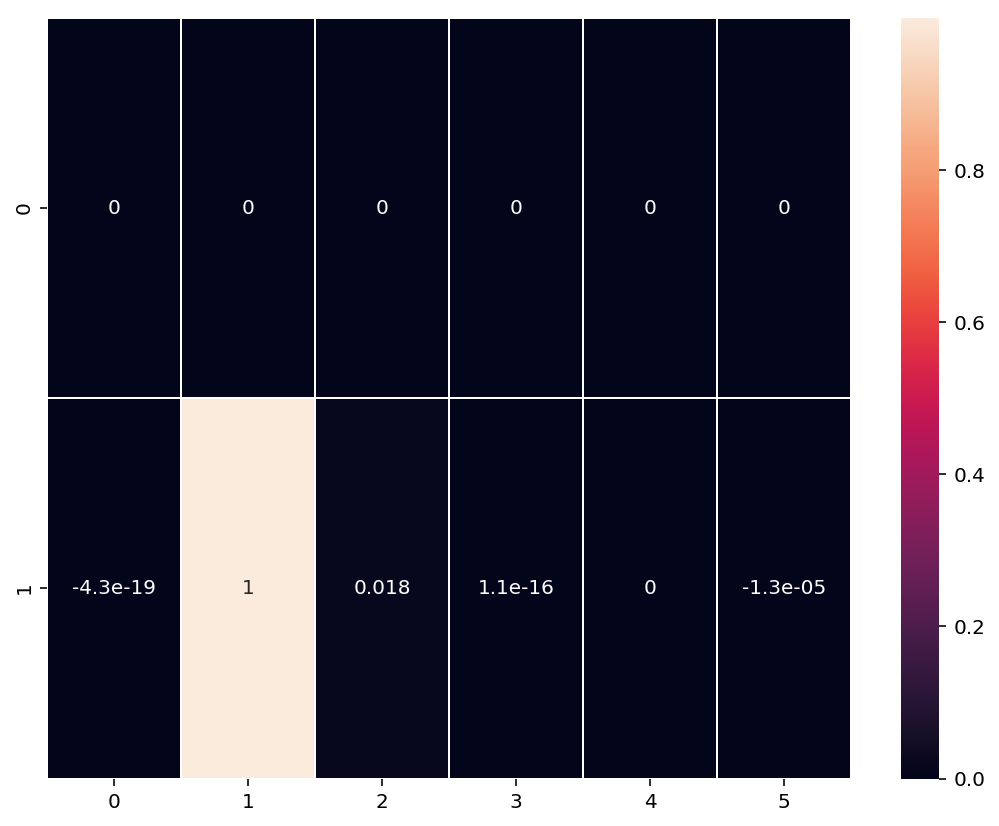

In [443]:
fig = plt.figure(figsize=(9, 7))
ax  = fig.add_subplot(111) 

data = np.vstack([np.zeros(6), eigvec[1]])
sns.heatmap(data, annot=True,  linewidths=.5)

**Вывод из блока сверху:**

Волновая функция в дисперсионном режиме слабо отличается вдали от антикроссинга от волновой функции невозмущенной системы $\hat{H} = \hat{H_q}\otimes \hat{1} + \hat{1} \otimes \hat{H_r}$

In [442]:
eigvec[1]

array([-4.33680869e-19,  9.99838049e-01,  1.79965301e-02,  1.11022302e-16,
        0.00000000e+00, -1.33814541e-05])


$|q\rangle \otimes |r\rangle$

## \end(TEST)

### Finally: диаграмма уровней $E_n(\phi)$

### не антикро$$инг

Text(0,0.5,'E, GHz')

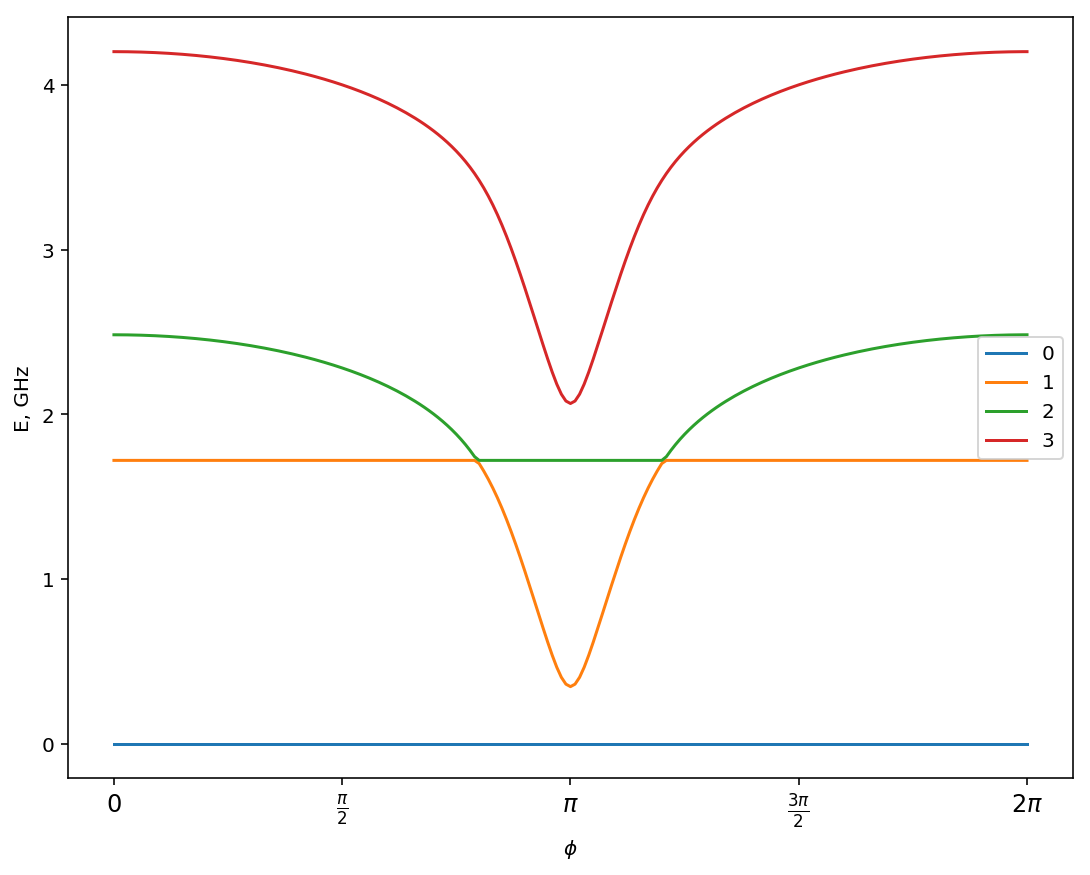

In [140]:
fig = plt.figure(figsize=(9, 7))
ax  = fig.add_subplot(111) 

x_label = [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$",   r"$2\pi$"]
x_tick = np.array([0, 0.5, 1, 1.5, 2])

ax.set_xticks(x_tick*np.pi)
ax.set_xticklabels(x_label, fontsize=12)

for i in range(nq*nr):
    plt.plot(φx_range, energies_raw[:, i], label=i)

    
plt.legend()

plt.xlabel("$\phi$")
plt.ylabel("E, GHz")

###  антикро$$инг

Text(0,0.5,'E, GHz')

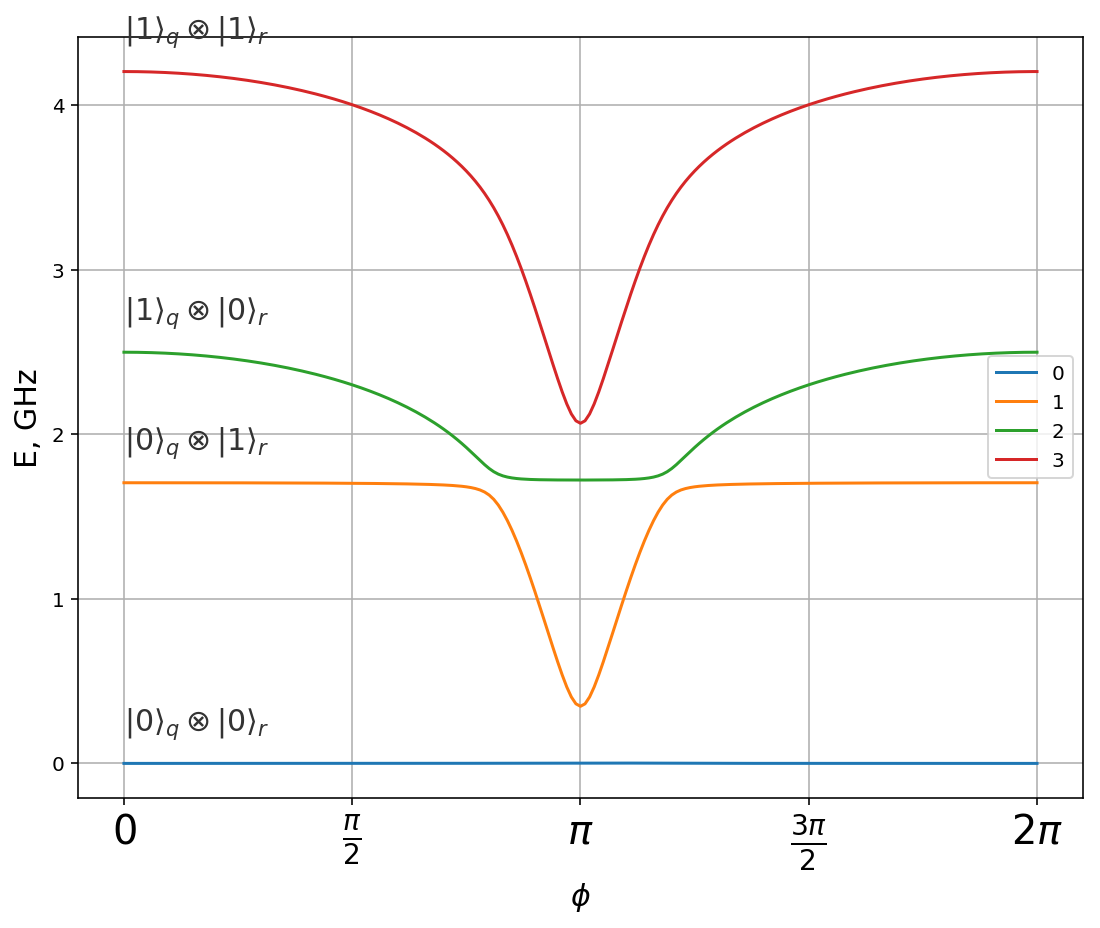

In [142]:
fig = plt.figure(figsize=(9, 7))
ax  = fig.add_subplot(111) 

x_label = [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$",   r"$2\pi$"]
x_tick = np.array([0, 0.5, 1, 1.5, 2])

ax.set_xticks(x_tick*np.pi)
ax.set_xticklabels(x_label, fontsize=20)

for i in range(nq*nr):
    ax.plot(φx_range, energies[:, i], label=i)
    
    tex = r'$|{}\rangle_q \otimes |{}\rangle_r$'.format(i //  nr, i % nr)
    mpl_grey_rvb = (51. / 255., 51. / 255., 51. / 255.)
    ax.annotate(tex, xy=(0, energies[:, i][0] + 0.2), fontsize=15, color=mpl_grey_rvb)





plt.legend()
plt.grid() 

plt.xlabel("$\phi$", fontsize=15)
plt.ylabel("E, GHz", fontsize=15)




https://en.wikipedia.org/wiki/Avoided_crossing

### BTW Мини-введение в передающие линии

Z0 = sqrt(Ll/Cl) = 50 Ohm
f = 1/(4*l*sqrt(Ll*Cl))

C = l*Cl/2
f = 1/(2*pi*sqrt(LC))


Далее работаем вблизи точки $\phi = \pi$

-----

# Часть 2:  $U^\dagger Q_q U$  

find 
* $\langle q=0, r=0|U^\dagger Q_q U  |q=0, r=1 \rangle$ 
* $\langle q=1, r=0|U^\dagger Q_q U  |q=1, r=1 \rangle$ 


In [143]:
Cq  = 60e-6
Cg  = 15e-6
Cr  = 250e-6

EJ  = 2.3
ELq = 1.1/2
ELr = 2.5  

φx  = np.pi  
# φx  = np.pi / 2 


nq  = 2
nr  = 2 


In [144]:
H, seed_q, seed_r = circuit_hamiltonian(
                        Cq=Cq, 
                        Cg=Cg, 
                        Cr=Cr, 
                        EJ=EJ, 
                        ELq=ELq, 
                        ELr=ELr, 
                        φx=φx, 
                        nq=nq, 
                        nr=nr)



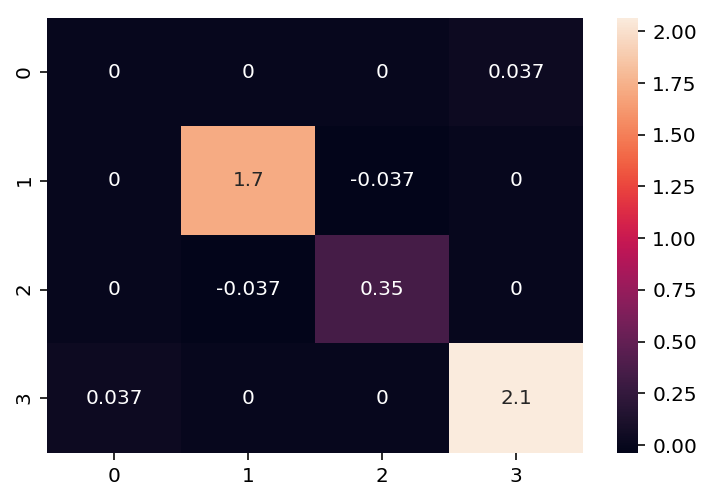

In [145]:
sns.heatmap(np.real(np.array(H)), annot=True)


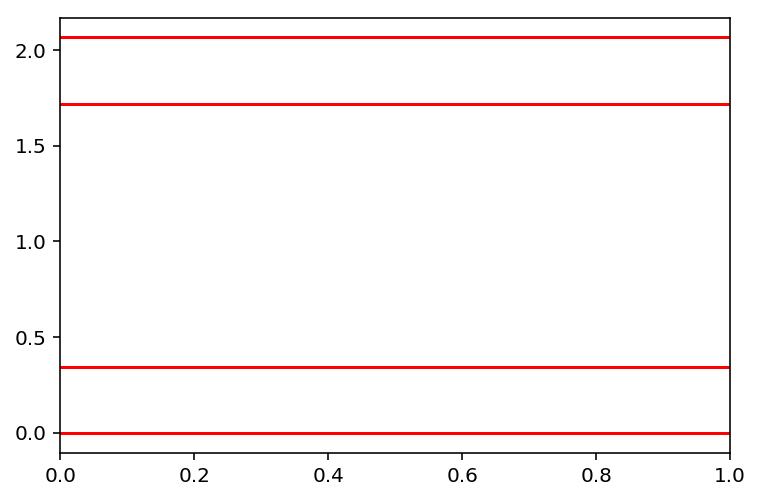

In [146]:
En = H.eigenenergies()
for each in En:
    plt.axhline(y=each, color='r', linestyle='-')




In [147]:
H.eigenstates()

(array([-6.56454838e-04,  3.44487462e-01,  1.72066254e+00,  2.06580645e+00]),
 array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.99984115]
  [ 0.        ]
  [ 0.        ]
  [-0.01782332]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.        ]
  [0.02676882]
  [0.99964165]
  [0.        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.        ]
  [ 0.99964165]
  [-0.02676882]
  [ 0.        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.01782332]
  [0.        ]
  [0.        ]
  [0.99984115]]], dtype=object))

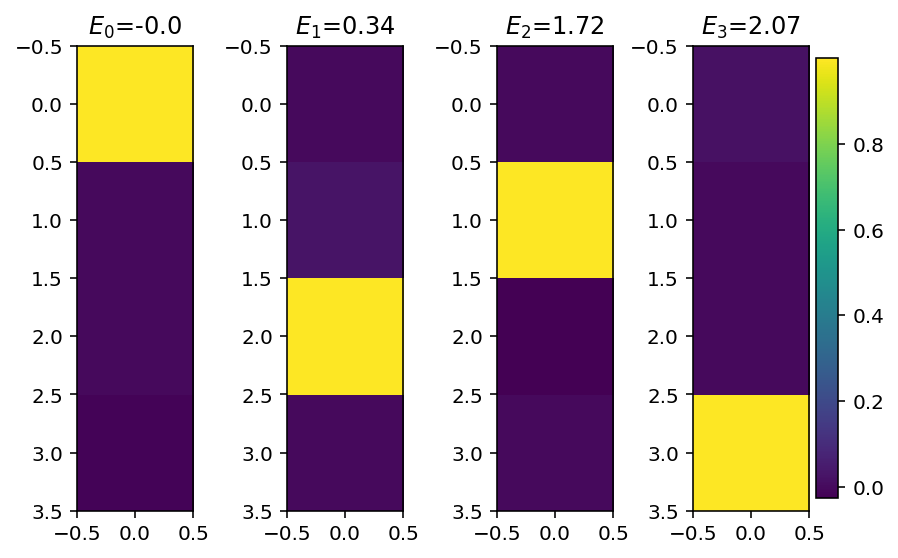

In [148]:
En = H.eigenenergies()

images = []

fig, axs = plt.subplots(1, nq*nr)
for i in range (nq * nr):
    data = np.real(np.array(H.eigenstates()[1][i])).reshape(nr*nq, 1)

    im = axs[i].imshow(data)
    images.append(im)
    axs[i].set_title(r"$E_{}$={}".format(i, np.around(En[i], decimals=2 )))

vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)

for im in images:
    im.set_norm(norm)
plt.tight_layout()

fig.colorbar(im)  



Нахождение матрицы перехода:

In [149]:
H_numpy = np.real(np.array(H))

In [150]:
_, eigenstates = np.linalg.eigh(H_numpy)


In [151]:
np.linalg.inv(eigenstates) @ H_numpy @ eigenstates

array([[-6.56454838e-04,  0.00000000e+00,  0.00000000e+00,
        -4.79497942e-18],
       [ 0.00000000e+00,  3.44487462e-01, -9.04771975e-18,
         0.00000000e+00],
       [ 0.00000000e+00, -5.93416481e-18,  1.72066254e+00,
         0.00000000e+00],
       [ 5.22573778e-18,  0.00000000e+00,  0.00000000e+00,
         2.06580645e+00]])

In [152]:
S = eigenstates

In [153]:
S.T @ H_numpy @ S

array([[-6.56454838e-04,  0.00000000e+00,  0.00000000e+00,
        -4.79497942e-18],
       [ 0.00000000e+00,  3.44487462e-01,  8.63110072e-19,
         0.00000000e+00],
       [ 0.00000000e+00,  7.93616336e-18,  1.72066254e+00,
         0.00000000e+00],
       [ 5.22573778e-18,  0.00000000e+00,  0.00000000e+00,
         2.06580645e+00]])

Нахождение матрицы заряда: 

In [154]:
def calculate_charge(Cq, Cg, Cr, EJ, ELq, ELr, φx, nq, nr, 
                        seed_q=None, seed_r=None):
    """
    nq -- число состояний кубита 
    nr -- число состояний резонатора 
    φx -- поток, измеряется в радианах
    """
    
    csubs = {C_q:Cq, C_g:Cg, C_r:Cr} 
    
    ECq = C_inv[0, 0].evalf(6, csubs) * e**2 / (2 * h)
    ECr = C_inv[1, 1].evalf(6, csubs) * e**2 / (2 * h) 
    
    Eq, Nq, seed_q = calculate_fluxonium(EJ, ECq, ELq, φx, num_states=nq, seed=seed_q)
    Er, Nr, seed_r = calculate_fluxonium( 0, ECr, ELr,  0, num_states=nr, seed=seed_r)
    
    
    Hq_ = qutip.Qobj(np.diag(Eq-np.min(Eq)), dims=[[nq], [nq]])
    Hr_ = qutip.Qobj(np.diag(Er-np.min(Er)), dims=[[nr], [nr]])
    
    Nq_ = qutip.Qobj(Nq, dims=[[nq], [nq]])
    Nr_ = qutip.Qobj(Nr, dims=[[nr], [nr]])
    
    
    Hq = qutip.tensor(Hq_, qutip.identity(nr))
    Hr = qutip.tensor(qutip.identity(nq), Hr_)
    
    Nq = qutip.tensor(Nq_, qutip.identity(nr))
    Nr = qutip.tensor(qutip.identity(nq), Nr_)
    
    H0 = Hq + Hr  
    

    V =  float(C_inv[0, 1].evalf(6, csubs) * (2*e)**2 / h)  * Nq * Nr 
    
    V.dims = H0.dims
    
    H = H0 + V 
    
    
    
    return Nq, Nr
    
    
    

In [155]:
N_q, N_r  = calculate_charge(Cq=Cq, 
                   Cg=Cg, 
                   Cr=Cr, 
                   EJ=EJ, 
                   ELq=ELq, 
                   ELr=ELr, 
                   φx=φx, 
                   nq=nq, 
                   nr=nr)



In [156]:
N_q

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+0.j        0.+0.j        0.-0.2581946j 0.+0.j       ]
 [0.+0.j        0.+0.j        0.+0.j        0.-0.2581946j]
 [0.+0.2581946j 0.+0.j        0.+0.j        0.+0.j       ]
 [0.+0.j        0.+0.2581946j 0.+0.j        0.+0.j       ]]

### N_q_transformed = $U^\dagger Q_q U$: 

In [157]:
S.T @ np.array(N_q) @ S

array([[0.+0.j        , 0.-0.25818427j, 0.+0.00231023j, 0.+0.j        ],
       [0.+0.25818427j, 0.+0.j        , 0.+0.j        , 0.-0.00231023j],
       [0.-0.00231023j, 0.+0.j        , 0.+0.j        , 0.-0.25818427j],
       [0.+0.j        , 0.+0.00231023j, 0.+0.25818427j, 0.+0.j        ]])

In [158]:
N_q_transformed = qutip.Qobj(S.T @ np.array(N_q) @ S)
N_q_transformed


Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+0.j         0.-0.25818427j 0.+0.00231023j 0.+0.j        ]
 [0.+0.25818427j 0.+0.j         0.+0.j         0.-0.00231023j]
 [0.-0.00231023j 0.+0.j         0.+0.j         0.-0.25818427j]
 [0.+0.j         0.+0.00231023j 0.+0.25818427j 0.+0.j        ]]

In [170]:
np.array([1, 0, 0, 0]).T @  np.array(N_q_transformed) @ np.array([0, 1, 0, 0])

-0.258184266362699j

In [171]:
np.array([0, 1, 0, 0]).T @  np.array(N_q_transformed) @ np.array([1, 0, 0, 0])

0.2581842663626989j

In [172]:
np.array([0, 0, 0, 1]).T @  np.array(N_q_transformed) @ np.array([0, 0, 1, 0])

0.258184266362699j

ИИИИииии...

In [167]:
ψ00 = H.eigenstates()[1][0]
ψ01 = H.eigenstates()[1][2]  
ψ10 = H.eigenstates()[1][1] 
ψ11 = H.eigenstates()[1][3]


# ψ00 = H.eigenstates()[1][0]
# ψ01 = H.eigenstates()[1][1]  
# ψ10 = H.eigenstates()[1][2] 
# ψ11 = H.eigenstates()[1][3]




In [168]:
np.imag(np.array(ψ01.dag()) @  np.array(N_q_transformed) @ np.array(ψ00))


array([[0.25803056]])

In [169]:
np.imag(np.array(ψ10.dag()) @  np.array(N_q_transformed) @ np.array(ψ11))



array([[-0.25803056]])

----

### SHIT

In [728]:
np.imag(np.array(ψ10.dag()) @  np.array(N_q_transformed) @ np.array(ψ11))


array([[-5.89805982e-17]])

In [729]:
np.imag(np.array(ψ11.dag()) @  np.array(N_q_transformed) @ np.array(ψ10))



array([[2.77555756e-17]])

In [770]:
N_q_transformed 

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+0.j         0.-0.12756796j 0.-0.75975586j 0.+0.j        ]
 [0.+0.12756796j 0.+0.j         0.+0.j         0.-0.75975586j]
 [0.+0.75975586j 0.+0.j         0.+0.j         0.+0.12756796j]
 [0.+0.j         0.+0.75975586j 0.-0.12756796j 0.+0.j        ]]

In [771]:
np.array(N_q_transformed)

array([[0.+0.j        , 0.-0.12756796j, 0.-0.75975586j, 0.+0.j        ],
       [0.+0.12756796j, 0.+0.j        , 0.+0.j        , 0.-0.75975586j],
       [0.+0.75975586j, 0.+0.j        , 0.+0.j        , 0.+0.12756796j],
       [0.+0.j        , 0.+0.75975586j, 0.-0.12756796j, 0.+0.j        ]])

In [789]:
np.array([1, 0, 0, 0]).T @ np.array(N_q_transformed) @ np.array([0, 1, 0, 0])

-0.12756796191266423j

In [793]:
np.array(ψ00).T @ np.array(N_q_transformed) @ np.array(ψ01)

array([[0.+1.11022302e-16j]])

In [799]:
np.array(ψ01)

array([[ 0.        +0.j],
       [ 0.99018372+0.j],
       [-0.13977197+0.j],
       [ 0.        +0.j]])

In [798]:
np.array([[0.        +0.j],
       [0.13977197+0.j],
       [0.99018372+0.j],
       [0.        +0.j]]).T 
@ np.array([[0.+0.j        , 0.-0.12756796j, 0.-0.75975586j, 0.+0.j        ],
       [0.+0.12756796j, 0.+0.j        , 0.+0.j        , 0.-0.75975586j],
       [0.+0.75975586j, 0.+0.j        , 0.+0.j        , 0.+0.12756796j],
       [0.+0.j        , 0.+0.75975586j, 0.-0.12756796j, 0.+0.j        ]]) 
@ np.array([[0.9996588 +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.02612069+0.j]])

array([[0.+0.77039117j]])

In [812]:
ψ00_np = np.array(ψ00) 
ψ01_np = np.array(ψ01)
ψ10_np = np.array(ψ10) 
ψ11_np = np.array(ψ11) 



In [804]:
ψ10_np.T @ np.array(N_q_transformed)  @ ψ11_np

array([[0.-5.89805982e-17j]])

In [808]:
np.real(ψ00_np.T) 

array([[0.9996588 , 0.        , 0.        , 0.02612069]])

In [805]:
np.array(N_q_transformed) == np.array([[0.+0.j        , 0.-0.12756796j, 0.-0.75975586j, 0.+0.j        ],
       [0.+0.12756796j, 0.+0.j        , 0.+0.j        , 0.-0.75975586j],
       [0.+0.75975586j, 0.+0.j        , 0.+0.j        , 0.+0.12756796j],
       [0.+0.j        , 0.+0.75975586j, 0.-0.12756796j, 0.+0.j        ]])

array([[ True, False, False,  True],
       [False,  True,  True, False],
       [False,  True,  True, False],
       [ True, False, False,  True]])

In [806]:
np.array([[0.+0.j        , 0.-0.12756796j, 0.-0.75975586j, 0.+0.j        ],
       [0.+0.12756796j, 0.+0.j        , 0.+0.j        , 0.-0.75975586j],
       [0.+0.75975586j, 0.+0.j        , 0.+0.j        , 0.+0.12756796j],
       [0.+0.j        , 0.+0.75975586j, 0.-0.12756796j, 0.+0.j        ]])  

array([[0.+0.j        , 0.-0.12756796j, 0.-0.75975586j, 0.+0.j        ],
       [0.+0.12756796j, 0.+0.j        , 0.+0.j        , 0.-0.75975586j],
       [0.+0.75975586j, 0.+0.j        , 0.+0.j        , 0.+0.12756796j],
       [0.+0.j        , 0.+0.75975586j, 0.-0.12756796j, 0.+0.j        ]])

In [807]:
np.array(N_q_transformed) 

array([[0.+0.j        , 0.-0.12756796j, 0.-0.75975586j, 0.+0.j        ],
       [0.+0.12756796j, 0.+0.j        , 0.+0.j        , 0.-0.75975586j],
       [0.+0.75975586j, 0.+0.j        , 0.+0.j        , 0.+0.12756796j],
       [0.+0.j        , 0.+0.75975586j, 0.-0.12756796j, 0.+0.j        ]])

In [811]:
np.real(ψ10_np.T) @ np.array([[0.+0.j        , 0.-0.12756796j, 0.-0.75975586j, 0.+0.j        ],
       [0.+0.12756796j, 0.+0.j        , 0.+0.j        , 0.-0.75975586j],
       [0.+0.75975586j, 0.+0.j        , 0.+0.j        , 0.+0.12756796j],
       [0.+0.j        , 0.+0.75975586j, 0.-0.12756796j, 0.+0.j        ]]) @ np.real(ψ11_np)







array([[0.-2.60347945e-09j]])

In [813]:
np.real(ψ00_np.T) 

array([[0.9996588 , 0.        , 0.        , 0.02612069]])

-----

In [817]:
np.array(ψ10 )

array([[0.        +0.j],
       [0.13977197+0.j],
       [0.99018372+0.j],
       [0.        +0.j]])

In [818]:
np.array(ψ11)

array([[-0.02612069+0.j],
       [ 0.        +0.j],
       [ 0.        +0.j],
       [ 0.9996588 +0.j]])

In [819]:
np.array(N_q)

array([[0.+0.j        , 0.+0.j        , 0.+0.77039116j, 0.+0.j        ],
       [0.+0.j        , 0.+0.j        , 0.+0.j        , 0.+0.77039116j],
       [0.-0.77039116j, 0.+0.j        , 0.+0.j        , 0.+0.j        ],
       [0.+0.j        , 0.-0.77039116j, 0.+0.j        , 0.+0.j        ]])

In [823]:
np.array(ψ01).T @ np.array(N_q) @ np.array(ψ11)

array([[0.+0.75975586j]])

In [824]:
np.array(ψ11).T @ np.array(N_q) @ np.array(ψ01)

array([[0.-0.75975586j]])

In [822]:
N_q 

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+0.j         0.+0.j         0.+0.77039116j 0.+0.j        ]
 [0.+0.j         0.+0.j         0.+0.j         0.+0.77039116j]
 [0.-0.77039116j 0.+0.j         0.+0.j         0.+0.j        ]
 [0.+0.j         0.-0.77039116j 0.+0.j         0.+0.j        ]]

In [825]:
np.array(ψ00).T @ np.array(N_q) @ np.array(ψ10)


array([[0.+0.75975586j]])

In [826]:
np.array(ψ11).T @ np.array(N_q) @ np.array(ψ01)


array([[0.-0.75975586j]])